# Computational Photography: Panorama Creation with OpenCV
In this notebook, we will explore how to create a panorama by stitching images together using OpenCV. We will walk through the key functions and explain how they work together to produce the final panorama. Each step will be demonstrated using examples.

## Images

I took these photos at Mist Creek, AB. The goal of this exercise is to use OpenCV to stitch them together and generate a panorama image.

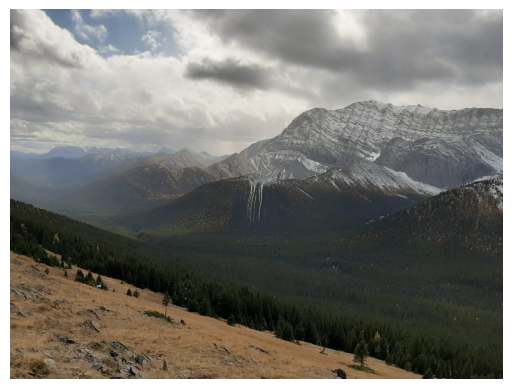

In [55]:
from matplotlib import pyplot as plt

def display_image_fp(filepath):
    image_1 = cv2.imread(filepath)
    image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
    plt.imshow(image_1_rgb)
    plt.axis('off')
    plt.show()


def display_image_np(nparray):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(nparray, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

display_image_fp('input_1.jpg')
    

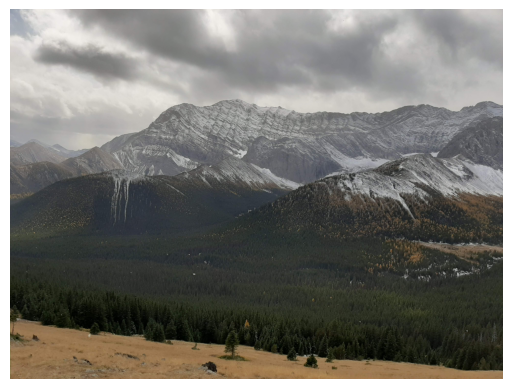

In [15]:
display_image('input_2.jpg')

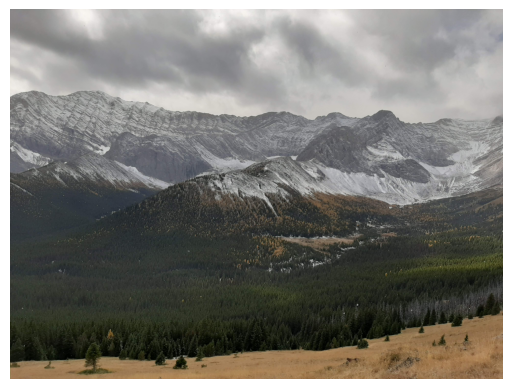

In [16]:
display_image('input_3.jpg')


## 1.1 Image Corners
First, we need a way to get the corners of an image. The `getImageCorners` function returns the coordinates of the four corners of an image, which will later be used to determine how images fit together.

In [2]:
import cv2
import numpy as np

def getImageCorners(image):
    corners = np.zeros((4, 1, 2), dtype=np.float32)
    height, width, _ = image.shape

    # Top left corner
    corners[0][0][0] = 0
    corners[0][0][1] = 0

    # Top right corner
    corners[1][0][0] = width
    corners[1][0][1] = 0

    # Bottom left corner
    corners[2][0][0] = 0
    corners[2][0][1] = height

    # Bottom right corner
    corners[3][0][0] = width
    corners[3][0][1] = height

    return corners


Let's test out that function on an example image:

In [17]:
image_1 = cv2.imread('input_1.jpg')
corners = getImageCorners(image_1)
print("Image Corners:", corners)

Image Corners: [[[   0.    0.]]

 [[4032.    0.]]

 [[   0. 3024.]]

 [[4032. 3024.]]]


## 1.2 Finding Matches Between Images
We use `findMatchesBetweenImages` to identify keypoints and descriptors in both images and find matching points. Here's how it works:

### 1. **Feature Detection:**
   The function uses **ORB (Oriented FAST and Rotated BRIEF)**, a common algorithm for detecting robust keypoints (distinctive image features like edges or corners). These keypoints are crucial because they remain consistent across changes in scale, lighting, and rotation. For both images:
   - `detectAndCompute` identifies keypoints and computes descriptors (binary vectors representing the local appearance around each keypoint).

### 2. **Feature Matching:**
   **Brute-force matching** is applied using `BFMatcher()`. This compares descriptors from both images and identifies the best matches based on **Hamming distance**, which is ideal for binary descriptors like ORB. The `crossCheck=True` option ensures that matching is mutual — both descriptors must match each other.

### 3. **Selecting Matches:**
   Matches are ranked by similarity (smallest distance) and the function returns only the top `num_matches` (default 50), providing the best feature correspondences.

### Return Values:
   - `image_1_kp` and `image_2_kp`: Keypoints from both images.
   - `matches`: The best keypoint matches between the two images.

This process is foundational for tasks like **panorama creation** or **object recognition**, where accurate alignment between images is needed.

In [19]:
def findMatchesBetweenImages(image_1, image_2, num_matches=50):
    feat_detector = cv2.ORB_create(nfeatures=500)
    image_1_kp, image_1_desc = feat_detector.detectAndCompute(image_1, None)
    image_2_kp, image_2_desc = feat_detector.detectAndCompute(image_2, None)
    bfm = cv2.BFMatcher(normType=cv2.NORM_HAMMING, crossCheck=True)
    matches = sorted(bfm.match(image_1_desc, image_2_desc), key=lambda x: x.distance)[:num_matches]
    return image_1_kp, image_2_kp, matches

In [20]:
image_2 = cv2.imread('input_2.jpg')
keypoints_1, keypoints_2, matches = findMatchesBetweenImages(image_1, image_2)
print(f"Number of matches found: {len(matches)}")

Number of matches found: 50


Let's show those first two images with the matches that were found displayed on top. The green lines are connecting locations of found matches from the two images.

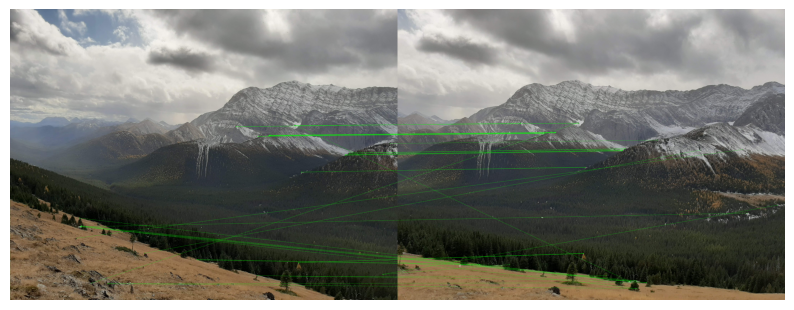

In [24]:
def displayMatches(image_1, image_1_kp, image_2, image_2_kp, matches, line_color=(0, 255, 0), line_thickness=2):
    # Draw the matches with specified line color and thickness
    match_image = cv2.drawMatches(
        image_1, image_1_kp, 
        image_2, image_2_kp, 
        matches, None, 
        matchColor=line_color,  # Color for the match lines (green by default)
        singlePointColor=(255,0,0),  # Color of the keypoints (default)
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    # Convert BGR to RGB for display in matplotlib
    match_image_rgb = cv2.cvtColor(match_image, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(match_image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

displayMatches(image_1, keypoints_1, image_2, keypoints_2, matches)

## 1.3 Finding Homography
The findHomography function calculates the transformation matrix (homography) that maps keypoints from one image to the next.

### Homography and `findHomography` in Depth

#### What is Homography?

A **homography** is a mathematical transformation that relates two planes in space. In the context of image processing, it's a mapping that aligns corresponding points between two images of the same scene taken from different perspectives.

In simpler terms, if two images are taken from different angles or positions, a homography matrix describes how to "warp" one image so that its keypoints (or features) align with the keypoints in the other image. This is especially useful in applications like image stitching (for panoramas), rectifying images, and 3D reconstruction.

The transformation captured by the homography can include:
- Rotation
- Translation (shifting the image)
- Scaling (changing the size)
- Perspective distortion (changes in the apparent shape due to viewing angles)

#### The Role of `findHomography`

The `cv2.findHomography()` function computes the homography matrix that maps corresponding keypoints between two images. It takes pairs of matching points from two images and calculates a 3x3 homography matrix.

#### Parameters and Process

The function works like this:

```python
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
```

1. **`points1` and `points2`**: These are sets of matching keypoints (features) in both images. You supply the coordinates of the points in both images that correspond to each other.
   
2. **`cv2.RANSAC` (Random Sample Consensus)**: This is a robust method that helps filter out "bad" matches or outliers. RANSAC iteratively selects a subset of matches and tries to compute a homography from them. Points that don’t fit the model are discarded as outliers, and only the "inliers" (correct matches) are used to compute the homography matrix.

#### Output

- **H**: The 3x3 homography matrix. This matrix can be used to transform or warp one image so that it aligns with the other.
- **mask**: A binary mask that indicates which matches are inliers (1) and which are outliers (0).

#### Example Use Case: Image Stitching

Imagine you're stitching two images together to create a panorama. You first detect keypoints in both images, then match them using a feature-matching algorithm. Once you have the matches, you calculate the homography matrix using `findHomography`.

With the homography matrix `H`, you can warp the second image to align with the first, which is the first step in stitching them together.

### Key Steps:
1. **Detect and match keypoints**: Use algorithms like ORB or SIFT to detect points in both images and match them.
2. **Estimate Homography**: Use the `findHomography` function to estimate the transformation between the two images.
3. **Warp the second image**: Using the homography matrix `H`, you can now warp the second image so that it aligns with the first image, making stitching or rectification possible.

Let's do that then!

In [26]:
def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.float64([image_1_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    image_2_points = np.float64([image_2_kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M_hom, _ = cv2.findHomography(image_1_points, image_2_points, method=cv2.RANSAC, ransacReprojThreshold=5.0)
    return M_hom

In [27]:
homography = findHomography(keypoints_1, keypoints_2, matches)
print("Homography Matrix:\n", homography)

Homography Matrix:
 [[ 1.87339705e+00  8.88756180e-03 -2.50418223e+03]
 [ 2.84538203e-01  1.53778783e+00 -7.79773597e+02]
 [ 2.10481746e-04 -2.57735314e-06  1.00000000e+00]]


## 1.4 Warping the Image
The warpCanvas function applies the homography to warp one image into the space of the other. It also shifts the image so that both images fit within a larger canvas.

In [36]:
def warpCanvas(image, homography, min_xy, max_xy):
    canvas_size = tuple(np.round(max_xy - min_xy).astype(int))

    # Step 1
    translation_matrix = np.identity(3)
    translation_matrix[0][2] = -min_xy[0]
    translation_matrix[1][2] = -min_xy[1]

    # Step 2
    homography = np.dot(translation_matrix, homography)

    # Step 3
    warped_image = cv2.warpPerspective(image, homography, canvas_size)
    return warped_image


def getBoundingCorners(corners_1, corners_2, homography):
    """Find the coordinates of the top left corner and bottom right corner of a
    rectangle bounding a canvas large enough to fit both the warped image_1 and
    image_2.
    """

    # Warp corners_1 using the homography
    corners_1 = cv2.perspectiveTransform(corners_1, homography)
    all_corners = np.concatenate((corners_1, corners_2), axis=0)

    # Ensure we are extracting scalars properly
    min_point = np.zeros(shape=2, dtype=np.float64)
    min_point[0] = all_corners[:, :, 0].min()
    min_point[1] = all_corners[:, :, 1].min()

    max_point = np.zeros(shape=2, dtype=np.float64)
    max_point[0] = all_corners[:, :, 0].max()
    max_point[1] = all_corners[:, :, 1].max()

    return min_point, max_point


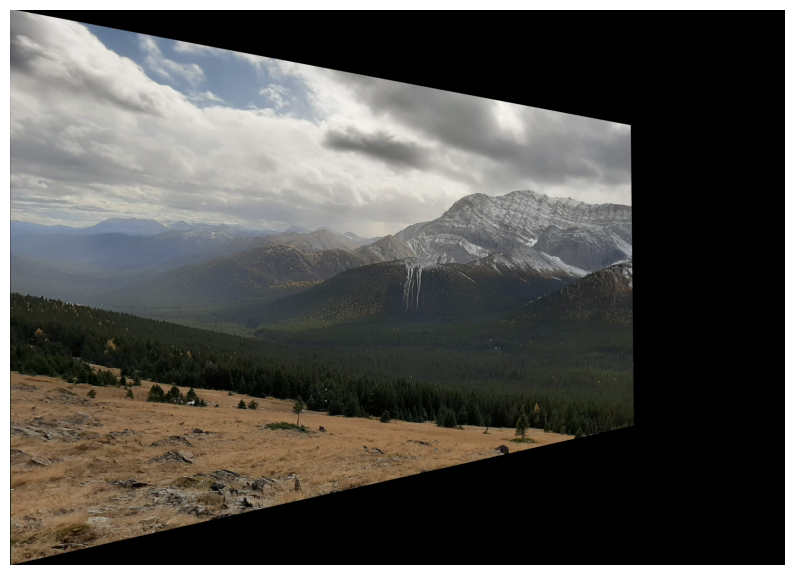

In [56]:
corners_1 = getImageCorners(image_1)
corners_2 = getImageCorners(image_2)
min_xy, max_xy = getBoundingCorners(corners_1, corners_2, homography)
warped_image_1 = warpCanvas(image_1, homography, min_xy, max_xy)

display_image_np(warped_image_1)

## 1.5 Blending the Images
Finally, after warping, we need to blend the images together to form a seamless panorama. We do this by creating masks for each image and combining them.

In [47]:
def createImageMask(image):
    h, w, _ = image.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Convert to grayscale if the image is colored
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply a binary threshold to get a binary image
    _, threshold = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the mask
    cv2.drawContours(mask, contours, -1, 255, -1)  # Use 255 for the mask
    
    # Convert mask to boolean if needed
    mask = mask.astype(bool)
    
    return mask
    
    return mask

In [63]:
mask_1 = createImageMask(warped_image_1)
mask_2 = createImageMask(image_2)

def display_mask(mask):
    # Ensure the mask is in uint8 format (0-255)
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray', interpolation='none')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

Here's what the first mask looks like:

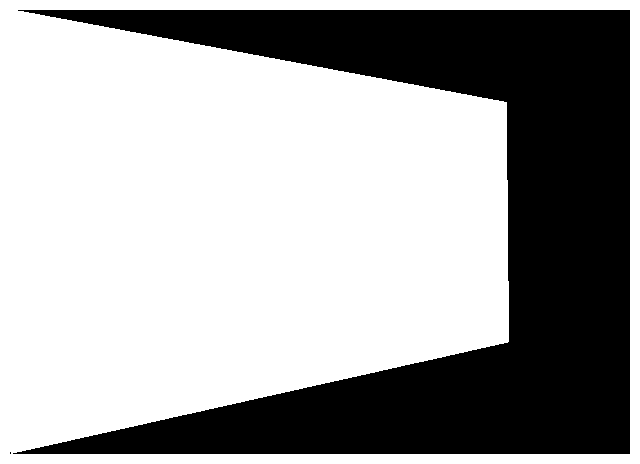

In [64]:
display_mask(mask_1)

These masks are then used to combine the images together. Each pixel gets multipled by the mask value, where black is 0. Meaning only that portion of the image is accepted in the final blended image.

In [66]:
import numpy as np
import scipy.ndimage as nd

def createRegionMasks(left_mask, right_mask):
    return np.logical_and(left_mask, np.logical_not(right_mask)), np.logical_and(left_mask, right_mask), np.logical_and(np.logical_not(left_mask), right_mask)

def findDistanceToMask(mask):
    return nd.distance_transform_edt(np.logical_not(mask))

def generateAlphaWeights(left_distance, right_distance):
    return np.divide(right_distance, (left_distance + right_distance))


## 1.6 Putting it All Together

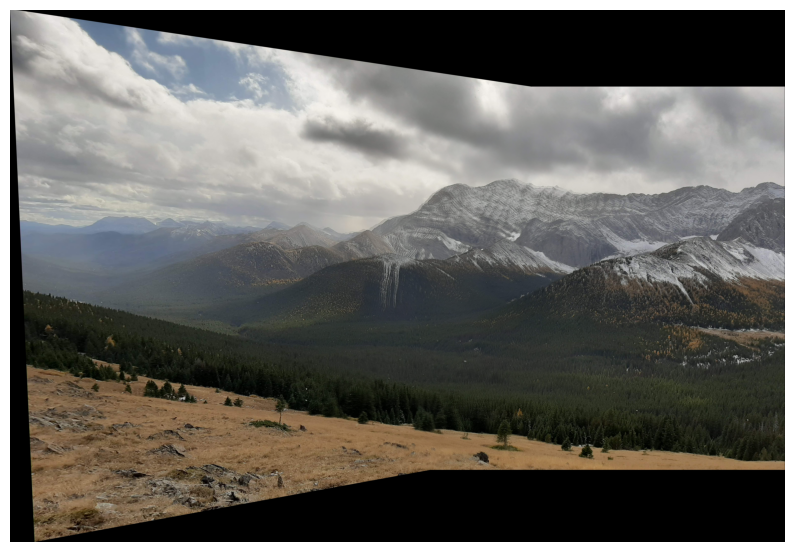

In [72]:
import numpy as np
import cv2

def blendImagePair(image_1, image_2, num_matches):
    kp1, kp2, matches = findMatchesBetweenImages(image_1, image_2, num_matches)
    homography = findHomography(kp1, kp2, matches)
    corners_1 = getImageCorners(image_1)
    corners_2 = getImageCorners(image_2)
    min_xy, max_xy = getBoundingCorners(corners_1, corners_2, homography)
    
    # Warp image_1 to align with image_2
    left_image = warpCanvas(image_1, homography, min_xy, max_xy)
    
    # Create a blank canvas for right_image and place image_2 on it
    right_image = np.zeros_like(left_image)
    min_xy_int = min_xy.astype(int)
    right_image[
        -min_xy_int[1]:-min_xy_int[1] + image_2.shape[0],
        -min_xy_int[0]:-min_xy_int[0] + image_2.shape[1]
    ] = image_2

    # Generate masks
    left_mask = createImageMask(left_image)
    right_mask = createImageMask(right_image)
    first_mask, second_mask, third_mask = createRegionMasks(left_mask, right_mask)

    # Calculate distance maps
    left_distance = findDistanceToMask(first_mask)
    right_distance = findDistanceToMask(third_mask)
    
    # Generate alpha weights
    alpha = generateAlphaWeights(left_distance, right_distance)
    
    # Ensure alpha has the correct number of channels
    if left_image.ndim == 3 and left_image.shape[2] == 3:
        alpha_3 = np.stack([alpha] * 3, axis=-1)
    else:
        alpha_3 = alpha[..., np.newaxis]

    # Blend images
    output_image = (alpha_3 * left_image + (1 - alpha_3) * right_image).astype(np.uint8)
    
    return output_image

blended_image_1 = blendImagePair(image_1, image_2, 20)
display_image_np(blended_image_1)

Finally, let's repeat that entire process again using this blended image, and the final (third image).

In [78]:
image_3 = cv2.imread('input_3.jpg')

blended_image_2 = blendImagePair(image_3, image_2, 20)

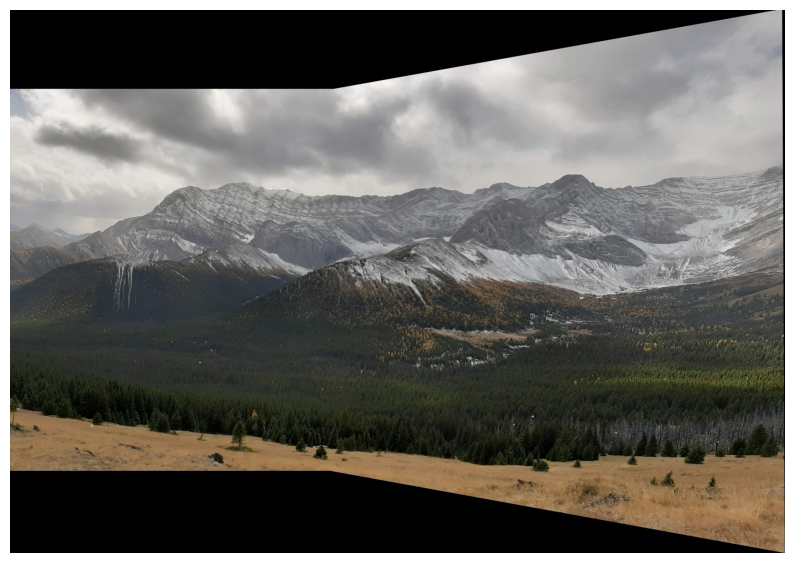

In [79]:
display_image_np(blended_image_2)

In [80]:
final_blended_image = blendImagePair(blended_image_1, blended_image_2, 20)

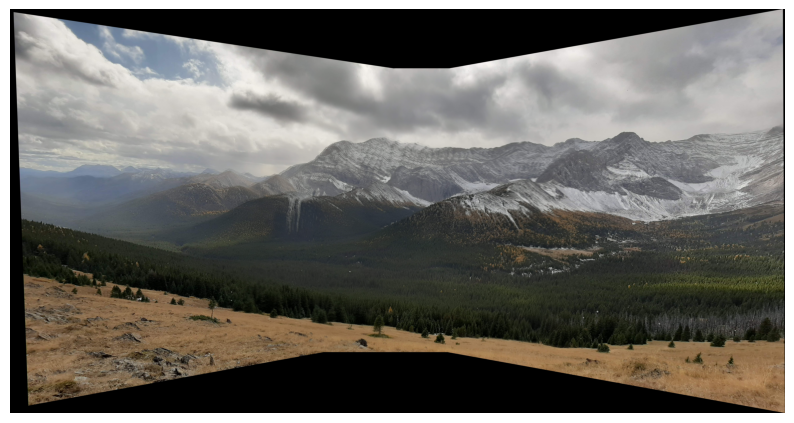

In [81]:
display_image_np(final_blended_image)

In [ ]:
cv2.imwrite(final_blended_image)